Описание проекта:
Заказчиком выступает интернет-магазин "В один клик", предоставляющий к продаже разные категории товаров (для детей, для дома, мелкую бытовую технику, косметику, продукты и пр.)
Учитывая снижение покупательской активности клиентов магазина, а так же исчерпание ресурса в привлечении новых покупателей, руководством было принято решение о применении машинного обучения с целью персонализации предложений постоянным клиентам, для увеличения их покупательской активности.

In [1]:
!pip install shap

In [2]:
pip install numpy==1.22

  Using cached numpy-1.22.0.zip (11.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [33 lines of output]
      Traceback (most recent call last):
        File "c:\Users\Borov\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
          main()
        File "c:\Users\Borov\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\Borov\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 112, in get_requires_for_build_wheel
          backend = _build_backend()
                    ^^^^^^^^^^^^^^^^
        File "c:\Users\Borov\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 77, in _build_backend
          obj = import_m

In [3]:
pip install matplotlib==3.8

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [5]:
# импорт библиотек, создание констант
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import shap
from phik.report import plot_correlation_matrix
from phik import report
RANDOM_STATE = 9
TEST_SIZE = 0.25

In [6]:
# загрузим, предоставленные для проекта данные
market_file = pd.read_csv('M:\csv\market_file.csv')
market_money = pd.read_csv('M:\csv\market_money.csv')
market_time = pd.read_csv('M:\csv\market_time.csv')
money = pd.read_csv('M:\csv\money.csv', sep=';', decimal=',')

Далее рассмотрим общую информацию о полученных таблицах с данными, а так же несколько примерно из каждой таблицы.

In [7]:
def inf(df):
    df.info()
    display(df.sample(6))

In [8]:
inf(market_file)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

id Покупательская активность Тип сервиса Разрешить сообщать  \
559   215907                 Снизилась    стандарт                 да   
741   216089           Прежний уровень    стандарт                нет   
543   215891           Прежний уровень    стандарт                 да   
964   216312           Прежний уровень    стандарт                 да   
1006  216354           Прежний уровень    стандарт                нет   
604   215952           Прежний уровень    стандарт                 да   

      Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
559                  6.6                     3           839   
741                  4.6                     4           561   
543                  4.8                     4           795   
964                  4.9                     5           215   
1006                 6.1                     5           823   
604                  4.9                     4           869   

      Акционные_покупки                  Популярная_категория  \
559                0.24                 Косметика и аксесуары   
741                0.20                      Товары для детей   
543                0.21                     Домашний текстиль   
964                0.15                     Домашний текстиль   
1006               0.25                      Товары для детей   
604                0.24  Мелкая бытовая техника и электроника   

      Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
559                                     3                                   3   
741                                     4                                   3   
543                                     4                                   5   
964                                     2                                   5   
1006                                    3                                   4   
604                                     3                                   1   

      Ошибка_сервиса  Страниц_за_визит  
559                4                15  
741                1                14  
543                7                16  
964                5                 8  
1006               6                15  
604                4                 8

In [9]:
inf(market_money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


id               Период  Выручка
336   215460  препредыдущий_месяц   4729.0
630   215558     предыдущий_месяц   6658.5
1237  215760     предыдущий_месяц   4989.0
92    215378  препредыдущий_месяц   4302.0
3762  216602  препредыдущий_месяц   4887.0
3617  216553        текущий_месяц   5149.4

In [10]:
inf(market_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


id            Период  минут
2116  216406  предыдцщий_месяц     20
1224  215960  предыдцщий_месяц     13
1291  215993  предыдцщий_месяц     18
1436  216066  предыдцщий_месяц     12
1251  215973  предыдцщий_месяц     17
1645  216170  предыдцщий_месяц     11

In [11]:
inf(money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


id  Прибыль
1037  216385     2.13
2     215350     3.13
147   215495     3.47
982   216330     4.44
315   215663     3.69
668   216016     1.68

При первичном просмотре имеющихся датафреймов можно сказать: 
- Отсутствуют пропуски
- Типы данных не нуждаются в корректировке 
- Данные соответствуют заявленным

## Проведем необходимую предобработку

In [12]:
# создадим функцию, с помощью которой рассмотрим уникальные категориальные признаки в наших датасетах, а так же наличае дупликатов
def uni_cat(df):
    list_cat_num = df.select_dtypes('object').columns
    display(list_cat_num)
    for i in list_cat_num:
        display(df[i].unique())
    print('Количество дупликатов: ', df.duplicated().sum())

In [13]:
uni_cat(market_file)

Index(['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Популярная_категория'],
      dtype='object')

array(['Снизилась', 'Прежний уровень'], dtype=object)

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

array(['да', 'нет'], dtype=object)

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

Количество дупликатов:  0


In [14]:
uni_cat(market_money)

Index(['Период'], dtype='object')

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Количество дупликатов:  0


In [15]:
uni_cat(market_time)

Index(['Период'], dtype='object')

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

Количество дупликатов:  0


In [16]:
# в данной таблице нет категориальных признаков, но тем не менее нужно исключить наличае дупликов
money.duplicated().sum()

0





Среди категориальных признаков обнаружились опечатки, которые нужно исправить, так же приведем названия колонок и самих категориальных значений к единому типу.

In [17]:
for g in [market_file, market_money, market_time, money]:
    g.columns = [re.sub(r' ', '_', i).lower() for i in g.columns]
    display(g.columns)
    
    list_cat_num = g.select_dtypes('object').columns
    for a in list_cat_num:
        g[a] = [re.sub(r' ', '_', b).lower() for b in g[a]]
        print(g[a].unique())

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

['снизилась' 'прежний_уровень']
['премиум' 'стандартт' 'стандарт']
['да' 'нет']
['товары_для_детей' 'домашний_текстиль' 'косметика_и_аксесуары'
 'техника_для_красоты_и_здоровья' 'кухонная_посуда'
 'мелкая_бытовая_техника_и_электроника']


Index(['id', 'период', 'выручка'], dtype='object')

['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


Index(['id', 'период', 'минут'], dtype='object')

['текущий_месяц' 'предыдцщий_месяц']


Index(['id', 'прибыль'], dtype='object')

In [18]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].str.replace('тт', 'т', regex=True)

In [19]:
market_time['период'] = market_time['период'].str.replace('дцщ', 'дущ', regex=True)

В результате предобработки данных было выполнено: 
- Названия колонок были приведены к общему виду
- Исправлены опечатки в категориальных данных 
- Датафремы исследованы на наличие дупликатов

## Исследовательский анализ данных 

In [20]:
# создадим функцию для визуализации количественных данных 
def function_quantity(df, column, xlabel, ylabel, title):
    bins =  plt.hist(df[column], bins=15)
    plt.vlines(x=df[column].mean(), colors='red', ymin=0, ymax=bins[0].max(), label='Среднее')
    plt.vlines(x=df[column].median(), colors='red', ymin=0, ymax=bins[0].max(), linestyles='--', label='Медиана')
    plt.title(f'{title}')
    plt.gca().set(xlabel=xlabel, ylabel=ylabel)
    plt.legend()
    plt.show()
    sns.boxplot(df[column])
    plt.show()

In [21]:
# создадим функцию для визуализации категориальных данных 
def function_cat(df, column, xlabel, ylabel, title):
    df = df[column].value_counts()
    plt.barh(df.index, df.values)
    plt.title(f'{title}')
    plt.gca().set(xlabel=xlabel, ylabel=ylabel)
    plt.show()

Рассмотрим распределения количественных признаков market_file, а так же их статистики.

In [22]:
market_file.set_index('id').describe()

маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
count         1300.000000           1300.000000   1300.000000   
mean             4.253769              4.011538    601.898462   
std              1.014814              0.696868    249.856289   
min              0.900000              3.000000    110.000000   
25%              3.700000              4.000000    405.500000   
50%              4.200000              4.000000    606.000000   
75%              4.900000              4.000000    806.000000   
max              6.600000              5.000000   1079.000000   

       акционные_покупки  средний_просмотр_категорий_за_визит  \
count        1300.000000                           1300.00000   
mean            0.319808                              3.27000   
std             0.249843                              1.35535   
min             0.000000                              1.00000   
25%             0.170000                              2.00000   
50%             0.240000                              3.00000   
75%             0.300000                              4.00000   
max             0.990000                              6.00000   

       неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  
count                         1300.000000     1300.000000       1300.000000  
mean                             2.840000        4.185385          8.176923  
std                              1.971451        1.955298          3.978126  
min                              0.000000        0.000000          1.000000  
25%                              1.000000        3.000000          5.000000  
50%                              3.000000        4.000000          8.000000  
75%                              4.000000        6.000000         11.000000  
max                             10.000000        9.000000         20.000000

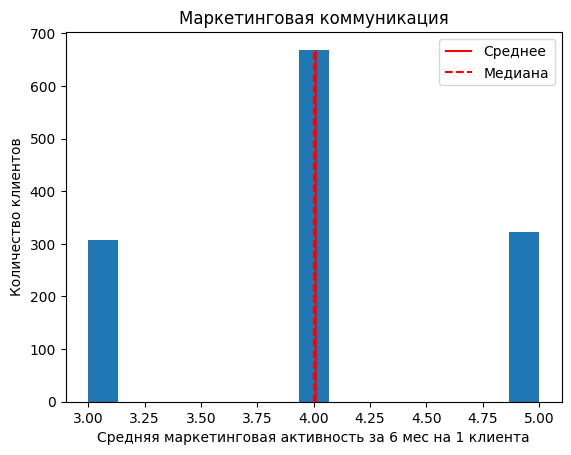

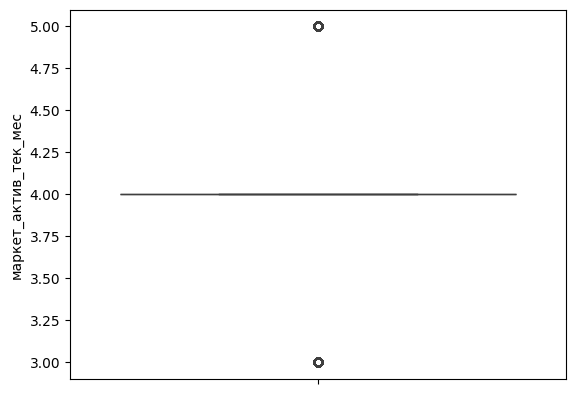

In [23]:
function_quantity(market_file,
                  'маркет_актив_тек_мес',
                  'Средняя маркетинговая активность за 6 мес на 1 клиента',
                  'Количество клиентов',
                  'Маркетинговая коммуникация')

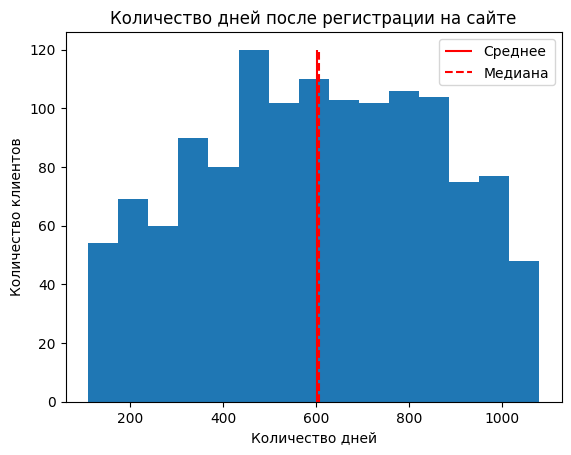

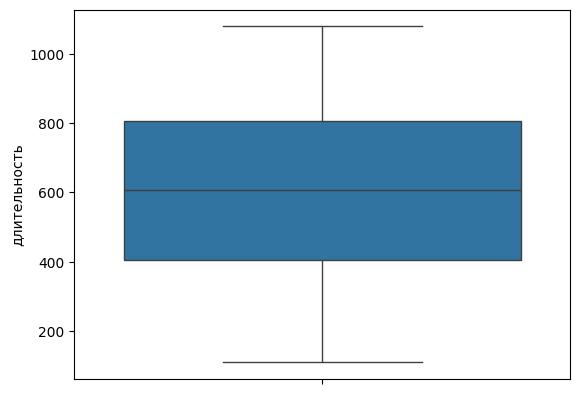

In [24]:
function_quantity(market_file,
                  'длительность',
                  'Количество дней',
                  'Количество клиентов',
                  'Количество дней после регистрации на сайте')

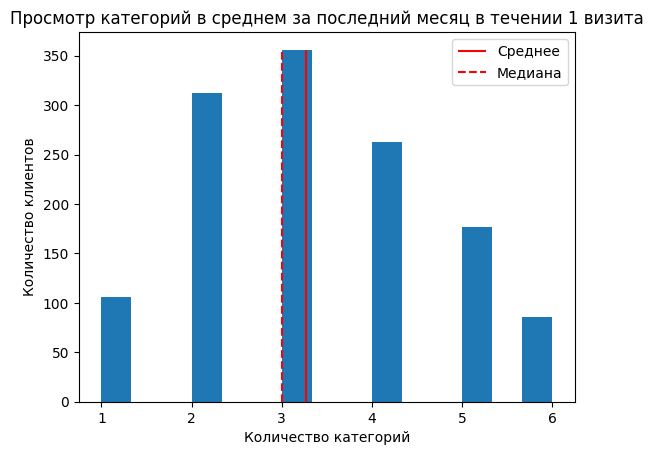

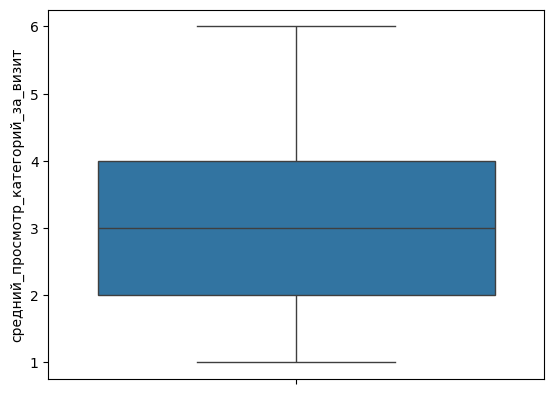

In [25]:
function_quantity(market_file,
                  'средний_просмотр_категорий_за_визит',
                  'Количество категорий',
                  'Количество клиентов',
                  'Просмотр категорий в среднем за последний месяц в течении 1 визита')

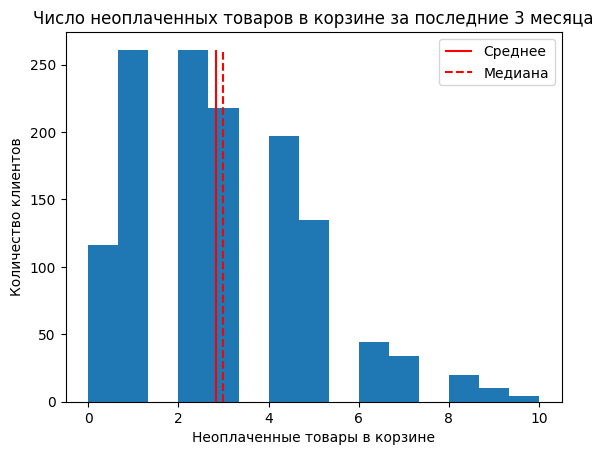

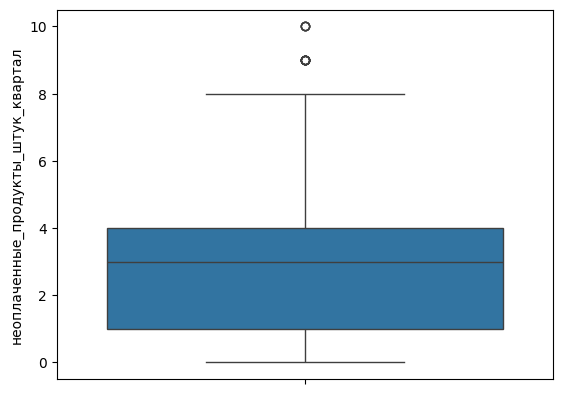

In [26]:
function_quantity(market_file,
                  'неоплаченные_продукты_штук_квартал',
                  'Неоплаченные товары в корзине',
                  'Количество клиентов',
                  'Число неоплаченных товаров в корзине за последние 3 месяца')

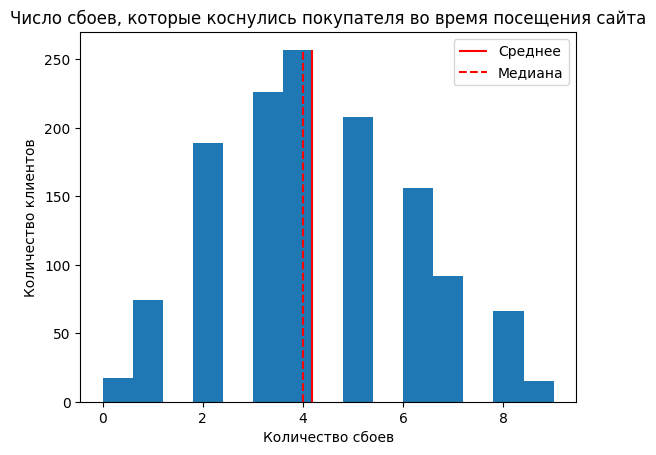

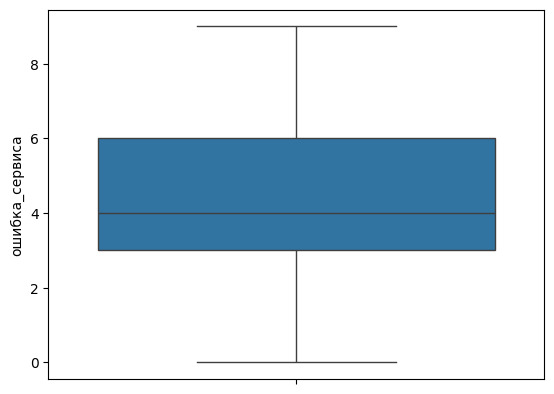

In [27]:
function_quantity(market_file,
                  'ошибка_сервиса',
                  'Количество сбоев',
                  'Количество клиентов',
                  'Число сбоев, которые коснулись покупателя во время посещения сайта')

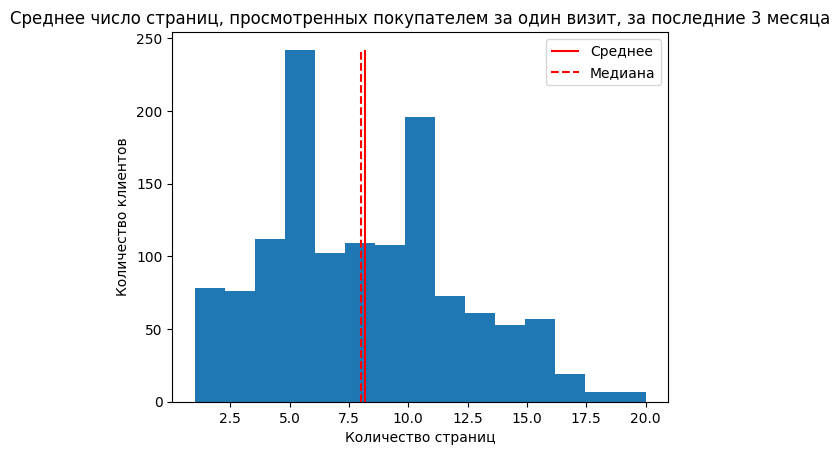

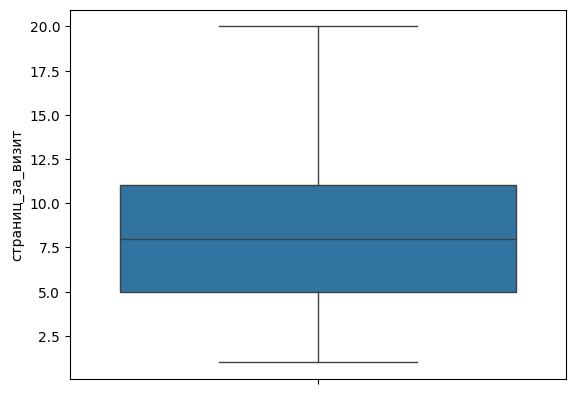

In [28]:
function_quantity(market_file,
                  'страниц_за_визит',
                  'Количество страниц',
                  'Количество клиентов',
                  'Cреднее число страниц, просмотренных покупателем за один визит, за последние 3 месяца')

Рассмотрим распределения категориальных признаков market_file

In [29]:
list_cat_num = market_file.select_dtypes('object').columns
list_cat_num

Index(['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'популярная_категория'],
      dtype='object')

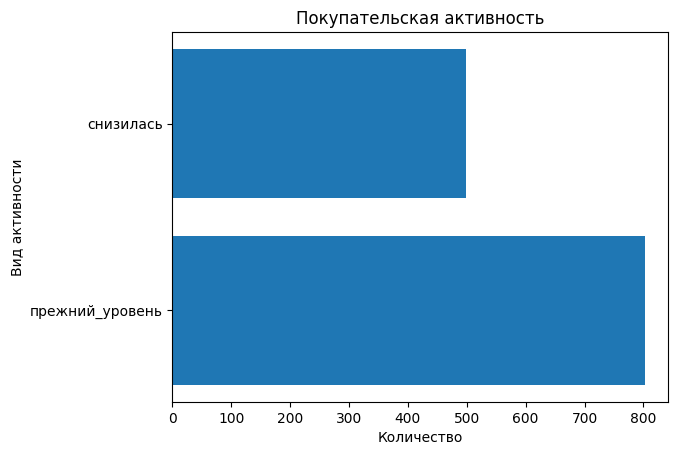

In [30]:
function_cat(market_file, 'покупательская_активность', 'Количество', 'Вид активности', 'Покупательская активность')


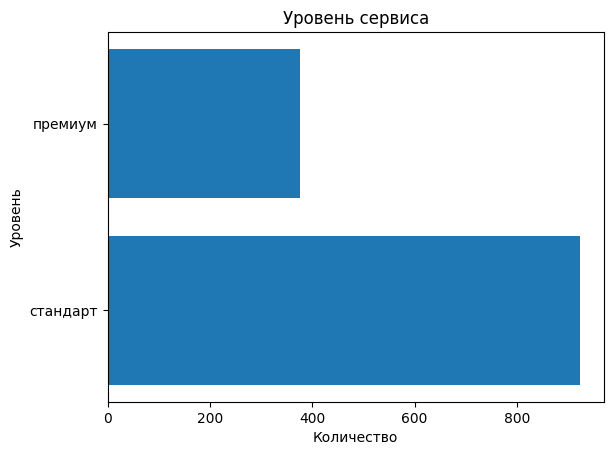

In [31]:
function_cat(market_file, 'тип_сервиса', 'Количество', 'Уровень', 'Уровень сервиса')

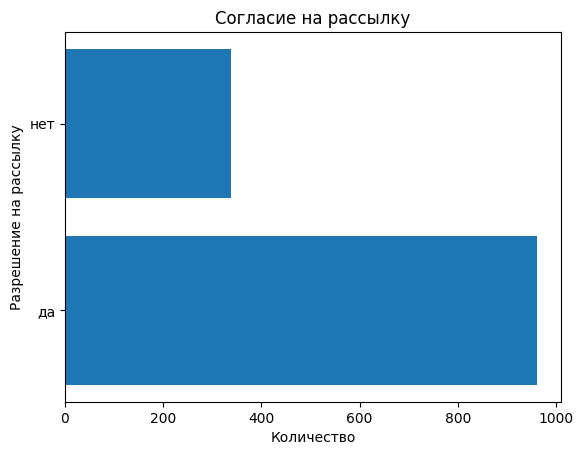

In [32]:
function_cat(market_file, 'разрешить_сообщать', 'Количество', 'Разрешение на рассылку', 'Согласие на рассылку')

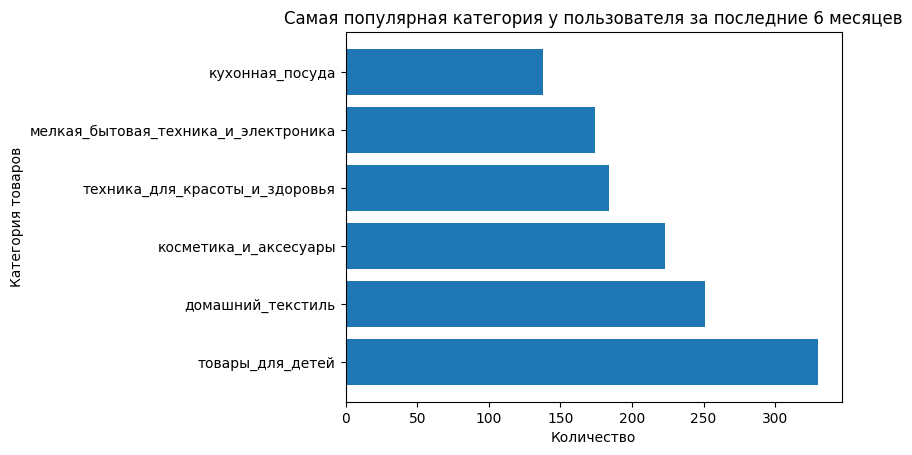

In [33]:
function_cat(market_file, 
             'популярная_категория',
             'Количество', 
             'Категория товаров',
             'Самая популярная категория у пользователя за последние 6 месяцев')




Теперь рассмотрим таблицу market_money

In [34]:
market_money.set_index('id').describe()
market_money.shape

(3900, 3)

Судя по статистикам имеются выбросы, попробуем их идентифицировать

In [35]:
market_money.loc[((market_money['выручка'] > 10000) | (market_money['выручка'] < 1000)), 'выручка']

0          0.0
2          0.0
28         0.0
29         0.0
34         0.0
35         0.0
98    106862.2
Name: выручка, dtype: float64

In [36]:
# удалим выбросы из данных
market_money = market_money[market_money['выручка'] < 106862.2]
market_money = market_money[market_money['выручка'] > 0]
market_money.shape

(3893, 3)

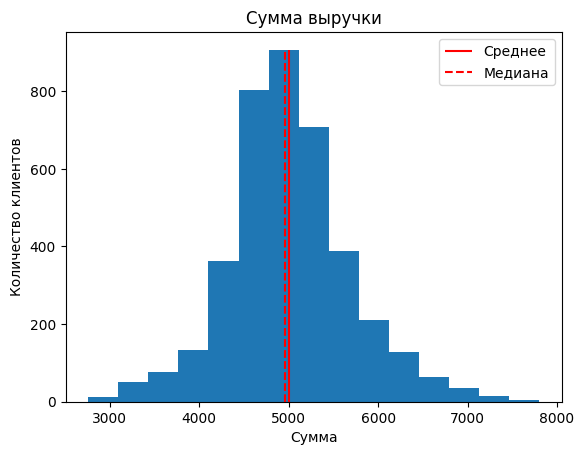

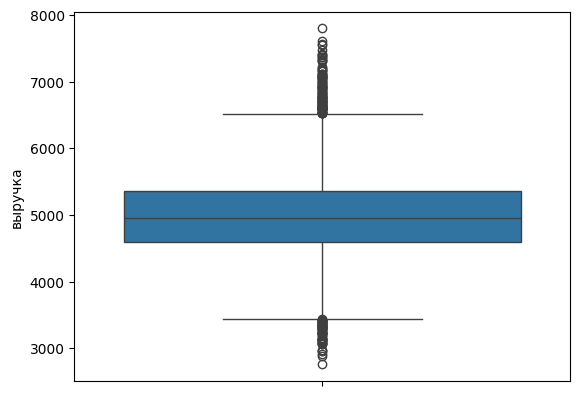

In [37]:
function_quantity(market_money,
                  'выручка',
                  'Сумма',
                  'Количество клиентов',
                  'Сумма выручки')

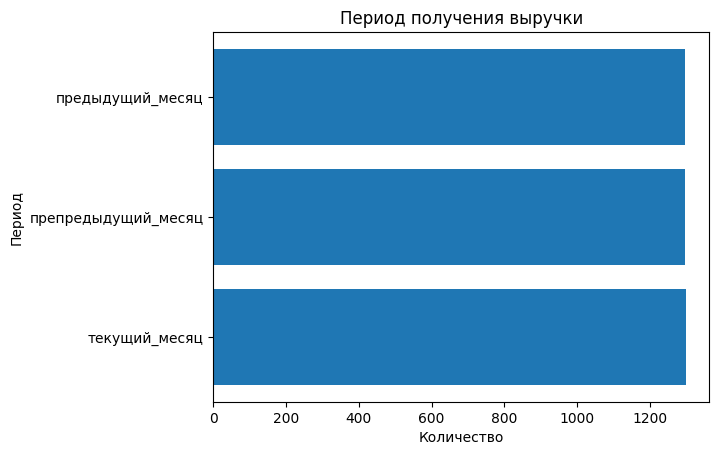

In [38]:
function_cat(market_money, 'период', 'Количество', 'Период', 'Период получения выручки')

Рассмотрим таблицу market_time

In [39]:
market_time.set_index('id').describe()

минут
count  2600.000000
mean     13.336154
std       4.080198
min       4.000000
25%      10.000000
50%      13.000000
75%      16.000000
max      23.000000

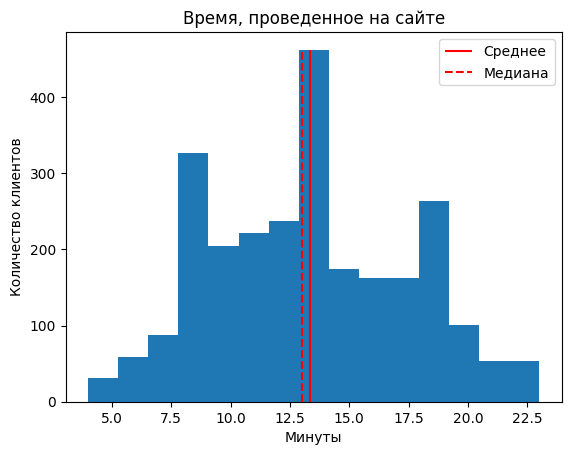

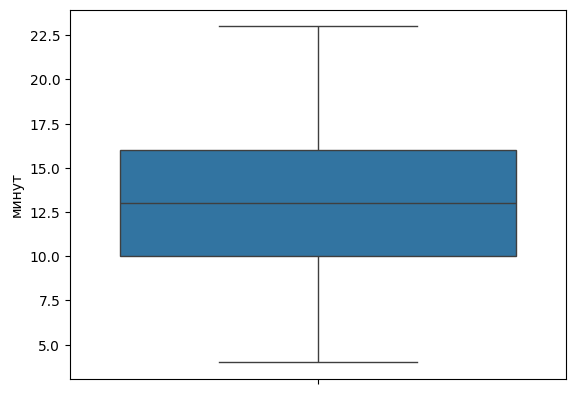

In [40]:
function_quantity(market_time,
                  'минут',
                  'Минуты',
                  'Количество клиентов',
                  'Время, проведенное на сайте')

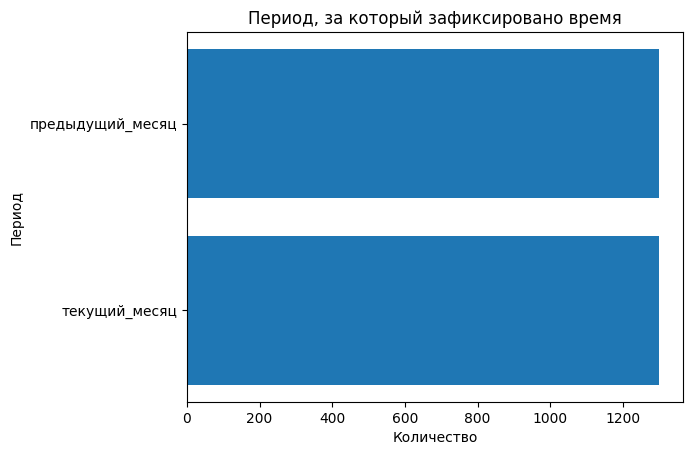

In [41]:
function_cat(market_time, 'период', 'Количество', 'Период', 'Период, за который зафиксировано время')

In [42]:
money.set_index('id').describe()

прибыль
count  1300.000000
mean      3.996631
std       1.013722
min       0.860000
25%       3.300000
50%       4.045000
75%       4.670000
max       7.430000

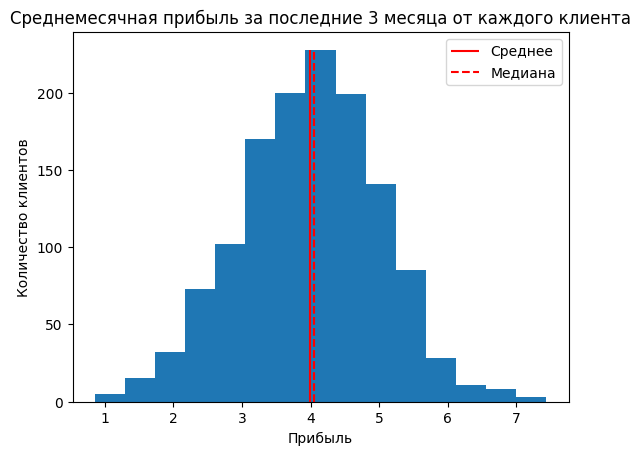

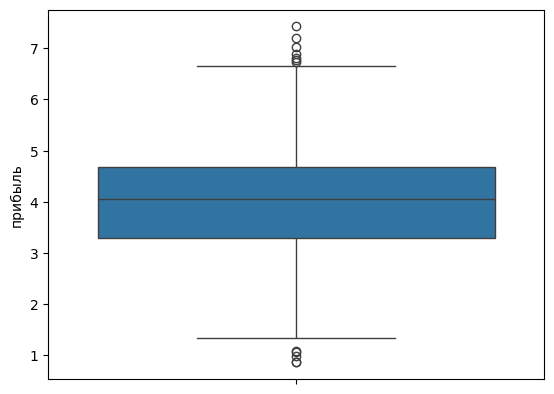

In [43]:
function_quantity(money,
                  'прибыль',
                  'Прибыль',
                  'Количество клиентов',
                  'Среднемесячная прибыль за последние 3 месяца от каждого клиента')

Выводы, касательно исследовательского анализа данных.
- Количественные данные в таблице market_file: 
 * Средняя маркетинговая активность за 6 мес на 1 клиента имеет всего 3 значения, с центром в значении 4.0
 * Количество дней после регистрации на сайте имеет распределение близкое к нормальному, с центром в значении 600 (медиана и      среднее практически совпадают)
 * Просмотр категорий в среднем за последний месяц в течении 1 визита распределено нормально, с небольшим смещением вправо
 * Число неоплаченных товаров в корзине за последние 3 месяца распределено ассиметрично, смещение направлено вправо, по данным    boxplot имеются правосторонние выбросы
 * Число сбоев, которые коснулись покупателя во время посещения сайта,в целом распределено нормально
 * Cреднее число страниц, просмотренных покупателем за один визит, за последние 3 месяца распределено ассиметрично, имеет 2        пика в области значений 6 и 11 соответственно, смещено вправо.
- Категориальные данные в таблицеmarket_file: 
 * По виду покупательской активности, у большинства клиентов она осталась на прежнем уровне (800 чел), у меньшей части (500       чел) она снизилась 
 * По типу сервиса клиентов с уровнем стандарт в 2 раза выше, чем с премиальными услугами
 * Порядка 2/3 пользователей согласны на рассылку 
 * Самая популярная категория товаров это детские, самая непопулярная - кухонная посуда 
 
 
- Количественные данные в таблице market_money представлены суммой выручки, имели аномальные значения, которые были удалены. Распределение нормальное, медиана и среднее близки друг к другу и расположены в окрестности значения 5000. Данные имею выбросы по обе стороны исходя из визуализации boxplot 
- Категориальные данные в таблице market_money представлены периодами получения прибыли за последние 3 месяца и распределеные поровну (т.е. данные о каждом клиенте за каждый из последних 3-х месяцев)
- Количественные данные в таблице market_time распределены близко к равномерному типу, имеют 3 ярко выраженных пика.
- Категориальные данные в таблице market_time поровну распределеные на текущий и предыдущий месяц
- Количественные данные в таблице money представлены среднемесячной прибылью за последние 3 месяца от каждого клиента, имеют нормальное распределение, медиана и среднее практически идентичны, имеются выбросы по обе стороны по данным boxplot



- Касательно отбора клиентов, которые что-либо покупали за поселдние 3 месяца - это данные нашей отфильтрованной от выбросов таблицы market_money

## Объединение таблиц

Перед объединением таблиц рассмотрим их колонки

In [44]:
market_file.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

In [45]:
market_money.columns

Index(['id', 'период', 'выручка'], dtype='object')

In [46]:
market_time.columns

Index(['id', 'период', 'минут'], dtype='object')

Две последние таблицы имеют колонки с одинаковым названием, отредактируем их

In [47]:
market_money = market_money.rename(columns={'период': 'период_money',})

In [48]:
market_time = market_time.rename(columns={'период': 'период_time',})

In [49]:
market_money = market_money.pivot_table(index='id', columns='период_money', aggfunc='sum')
market_money

выручка                                  
период_money предыдущий_месяц препредыдущий_месяц текущий_месяц
id                                                             
215348                    NaN                 NaN        3293.1
215349                 5216.0              4472.0        4971.6
215350                 5457.5              4826.0        5058.4
215351                 6158.0              4793.0        6610.4
215352                 5807.5              4594.0        5872.5
...                       ...                 ...           ...
216643                 3664.0              4704.0        4741.7
216644                 4729.0              5299.0        5353.0
216645                 5160.0              5334.0        5139.2
216646                 4923.0              4725.0        5224.6
216647                 4720.0              5183.0        4448.3

[1300 rows x 3 columns]

In [50]:
market_time = market_time.pivot_table(index='id', columns='период_time', aggfunc='sum')
market_time

минут              
период_time предыдущий_месяц текущий_месяц
id                                        
215348                    13            14
215349                    12            10
215350                     8            13
215351                    11            13
215352                     8            11
...                      ...           ...
216643                    14             7
216644                    12            11
216645                    12            18
216646                    18             7
216647                    15            10

[1300 rows x 2 columns]

Объединим таблицы

In [51]:
df = market_file.merge(market_money, on='id', how = 'left')
df = df.merge(market_time, on='id', how = 'left')

MergeError: Not allowed to merge between different levels. (1 levels on the left, 2 on the right)

In [ ]:
df = df.rename(columns={('выручка', 'предыдущий_месяц'): 'выручка_ предыдущий_месяц',
             ('выручка', 'препредыдущий_месяц'): 'выручка_ препредыдущий_месяц',
             ('выручка', 'текущий_месяц'): 'выручка_ текущий_месяц',
             ('минут', 'предыдущий_месяц'): 'минут_предыдущий_месяц',
              ('минут', 'текущий_месяц'): 'минут_текущий_месяц'})

In [ ]:
df.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_ предыдущий_месяц              3
выручка_ препредыдущий_месяц           3
выручка_ текущий_месяц                 1
минут_предыдущий_месяц                 0
минут_текущий_месяц                    0
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
df

id покупательская_активность тип_сервиса разрешить_сообщать  \
1     215349                 снизилась     премиум                 да   
2     215350                 снизилась    стандарт                нет   
3     215351                 снизилась    стандарт                 да   
4     215352                 снизилась    стандарт                нет   
5     215353                 снизилась    стандарт                 да   
...      ...                       ...         ...                ...   
1295  216643           прежний_уровень    стандарт                 да   
1296  216644           прежний_уровень    стандарт                нет   
1297  216645           прежний_уровень    стандарт                 да   
1298  216646           прежний_уровень    стандарт                 да   
1299  216647           прежний_уровень     премиум                 да   

      маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
1                    4.4                     4           819   
2                    4.9                     3           539   
3                    3.2                     5           896   
4                    5.1                     3          1064   
5                    3.3                     4           762   
...                  ...                   ...           ...   
1295                 6.6                     3           318   
1296                 5.1                     4           454   
1297                 4.1                     3           586   
1298                 6.3                     5           645   
1299                 4.0                     5           906   

      акционные_покупки            популярная_категория  \
1                  0.75                товары_для_детей   
2                  0.14               домашний_текстиль   
3                  0.99                товары_для_детей   
4                  0.94                товары_для_детей   
5                  0.26               домашний_текстиль   
...                 ...                             ...   
1295               0.24  техника_для_красоты_и_здоровья   
1296               0.21               домашний_текстиль   
1297               0.20               домашний_текстиль   
1298               0.12  техника_для_красоты_и_здоровья   
1299               0.94  техника_для_красоты_и_здоровья   

      средний_просмотр_категорий_за_визит  неоплаченные_продукты_штук_квартал  \
1                                       4                                   4   
2                                       5                                   2   
3                                       5                                   0   
4                                       3                                   2   
5                                       4                                   1   
...                                   ...                                 ...   
1295                                    5                                   3   
1296                                    6                                   2   
1297                                    3                                   2   
1298                                    3                                   3   
1299                                    4                                   5   

      ошибка_сервиса  страниц_за_визит  выручка_ предыдущий_месяц  \
1                  2                 5                     5216.0   
2                  1                 5                     5457.5   
3                  6                 4                     6158.0   
4                  3                 2                     5807.5   
5                  1                 4                     4738.5   
...              ...               ...                        ...   
1295               3                11                     3664.0   
1296               3                 9                     4729.0   
1297               5                 7                     51

## Корреляционный анализ

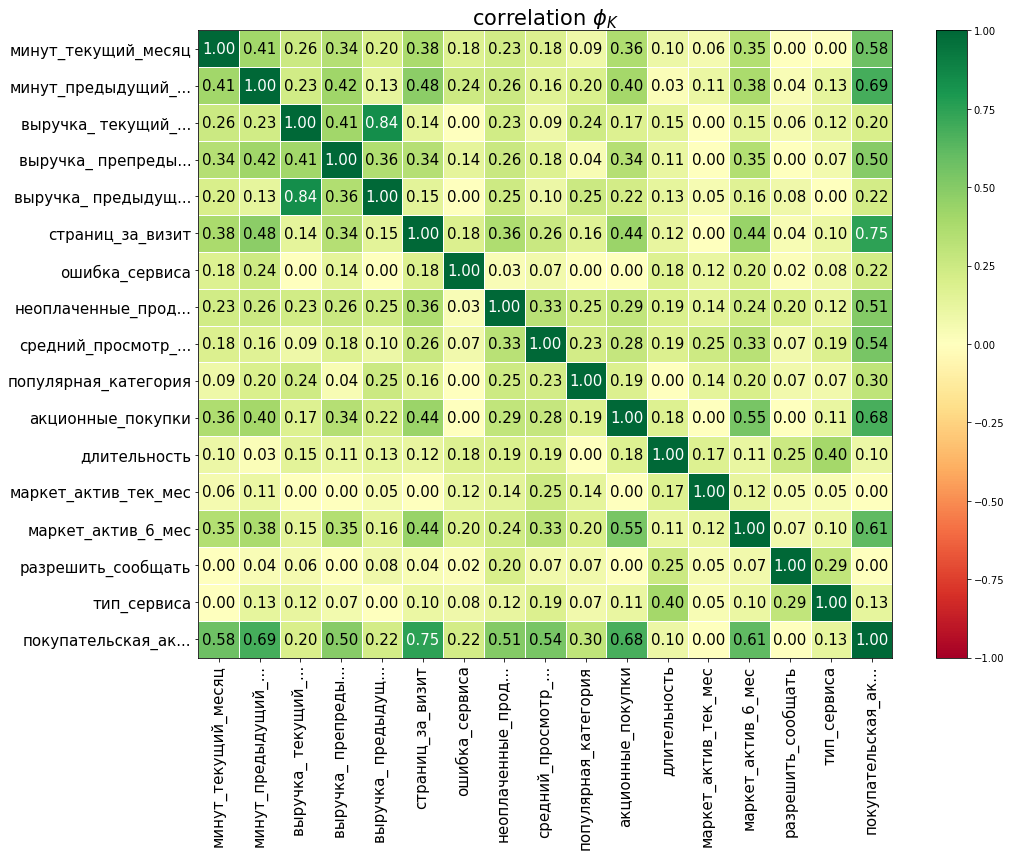

In [ ]:
interval_cols = ['маркет_актив_тек_мес', 'длительность',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_ предыдущий_месяц',
        'выручка_ препредыдущий_месяц',
        'выручка_ текущий_месяц',
        'минут_предыдущий_месяц',
        'минут_текущий_месяц']

phik_overview = df.set_index('id').phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

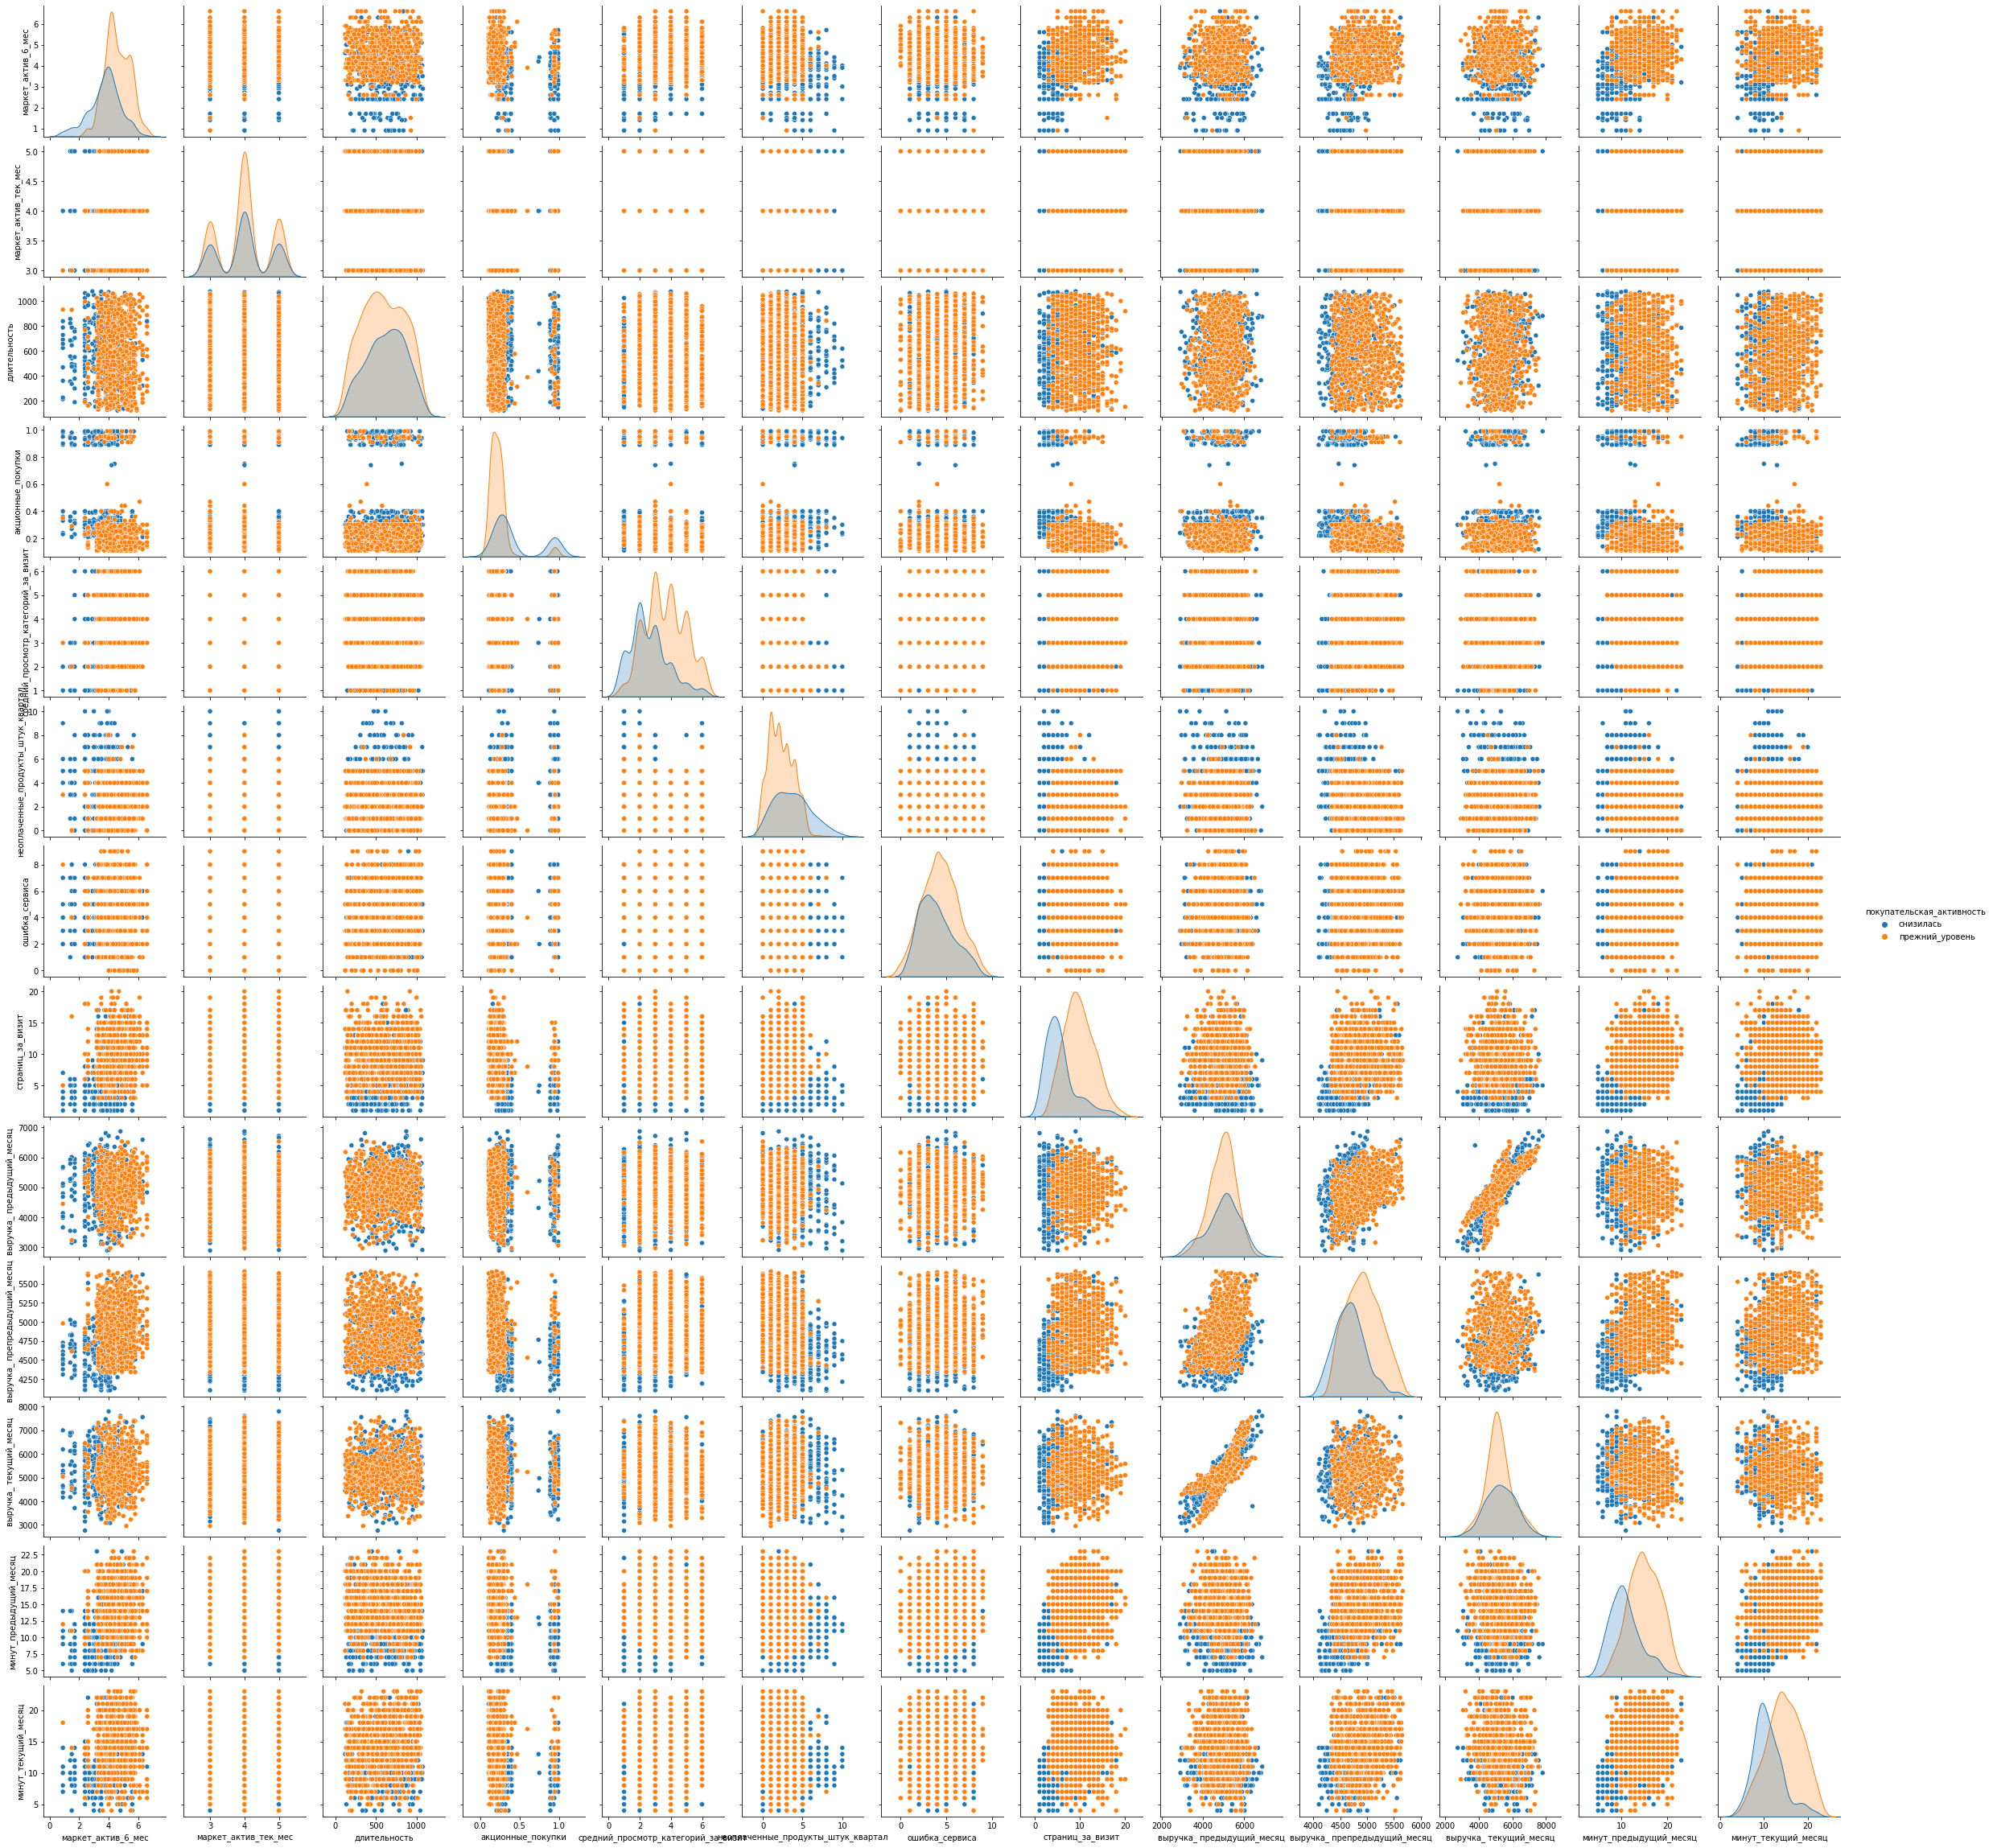

In [ ]:
sns.pairplot(df.set_index('id'), hue='покупательская_активность')
plt.show();

Покупательская активность коррелирует с количеством минут в разных месяцах, количеством страниц за визит, акционными покупками с высокой степенью,  с маркетинговой активностью, неоплаченными товарами в корзине, средним просмотром страниц со средней степенью.
Акционные покупки коррелируют с выручкой в прошлые месяцы с высокой степенью.
Так же между собой с высокой степенью коррелируют выручки в разных месяцах.

## Использование пайплайнов

In [ ]:
y = df['покупательская_активность'].apply(lambda x: 1 if x == 'снизилась' else 0)
X = df.drop(['покупательская_активность', 'id'], axis=1)

In [ ]:
# разбиваем выборку на тренировочную и тестовую 
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify=y)

In [ ]:
# создаём списки с названиями признаков
ohe_columns = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
num_columns = ['маркет_актив_тек_мес', 'длительность',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_ предыдущий_месяц',
        'выручка_ препредыдущий_месяц',
        'выручка_ текущий_месяц',
        'минут_предыдущий_месяц',
        'минут_текущий_месяц']
ord_columns = ['тип_сервиса']

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', OneHotEncoder(drop='first', handle_unknown='error'), ohe_columns),
     ('ord', OrdinalEncoder(), ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    

    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(probability= True, random_state=RANDOM_STATE)],
        'models__kernel': ['linear']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred = randomized_search.predict(X_test)
probabilities = randomized_search.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, probabilities_one)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord', OrdinalEncoder(),
                                                  ['тип_сервиса']),
                                                 ('num', 'passthrough',
                                                  ['маркет_актив_тек_мес',
                                                   'длительность',
                                                   'средний_просмотр_категорий_за_визит',
                                                   'неоплаченные_продукты_шт

Для оценки качества лучше модели выбрана метрика roc-auc, т.к. она позволяет оценить динамику качества классификации при разных порогах классификации. Лучшее качество модели — в точке перелома кривой. Площадь под кривой оценивает качество решений модели в наиболее общем виде, учитывая все возможные пороговые значения.

Таким обзаром лучшей моделью оказалась логистическая регрессия

## Анализ важности признаков

In [ ]:
# подготовим данные с использованием лучшего трансформера
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify=y)

encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train_2[ohe_columns])
X_test_ohe = encoder.transform(X_test_2[ohe_columns])

encoder_col_names = encoder.get_feature_names()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)

X_train_2 = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_2 = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [ ]:
# создадим и обучим модель с лучшими параметрами
model = LogisticRegression(C=1, penalty='l1', solver='liblinear', random_state=RANDOM_STATE) 

model.fit(X_train_2, y_train_2)
y_test_pred = model.predict(X_test_2)

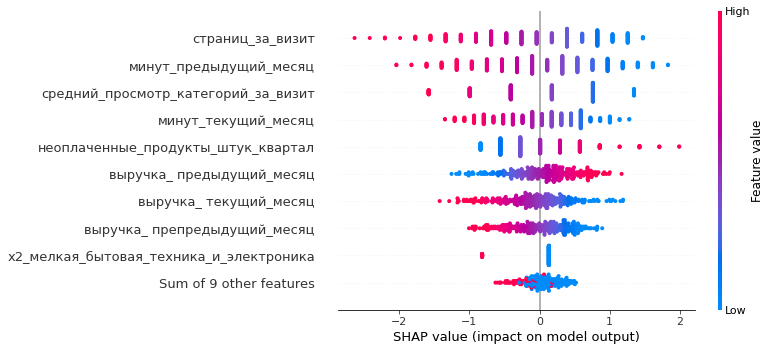

In [ ]:
explainer = shap.LinearExplainer(randomized_search.best_estimator_.named_steps['models'].predict_proba, X_train)
shap_values = explainer(X_test_2)

shap.plots.beeswarm(shap_values) 

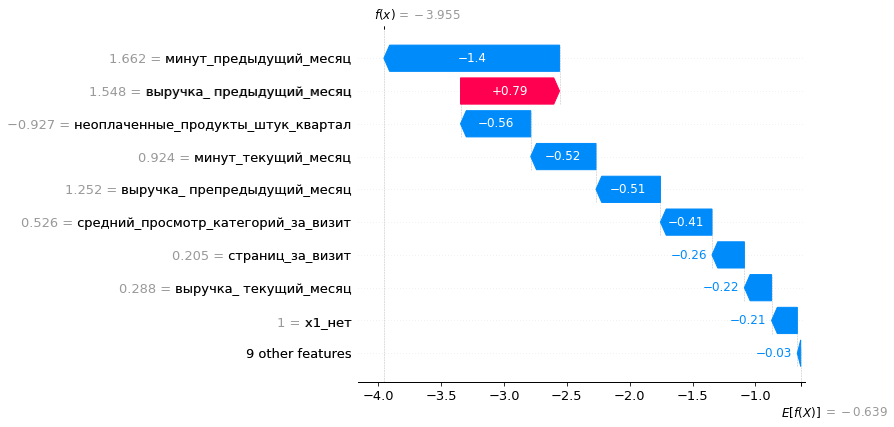

In [ ]:
shap.plots.waterfall(shap_values[10]) 

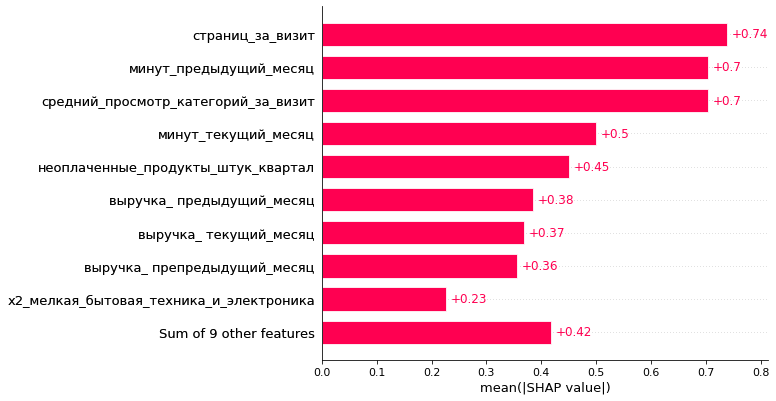

In [ ]:
shap.plots.bar(shap_values) 


По итогу наиболее важные признаки для модели это число страниц за визит, количество минут, средний просмотр категорий за визит.

## Сегментация покупателей

Выполним селекцию покупателей лучшей моделью на всех данных с уменьшенным порогом, для отбора покупателей, для которых снизилась покупательская активность и объединим полученные данные с данными о прибыльности.

In [ ]:
best_model = randomized_search.best_estimator_
predictions = best_model.predict_proba(X)[:, 1]

In [ ]:
prediction_threshold = np.where(predictions > 0.9, True, False)

Установим максимально низкий порог модели, что бы быть уверенными что подавляющее большинство отобранны верно и мы будем воздействовать на нужную нам группу

In [ ]:
df_seg = df.loc[prediction_threshold]

In [ ]:
df_seg_money = df_seg.merge(money, on='id', how = 'left')

In [ ]:
df_seg_money.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 0 to 267
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   268 non-null    int64  
 1   покупательская_активность            268 non-null    object 
 2   тип_сервиса                          268 non-null    object 
 3   разрешить_сообщать                   268 non-null    object 
 4   маркет_актив_6_мес                   268 non-null    float64
 5   маркет_актив_тек_мес                 268 non-null    int64  
 6   длительность                         268 non-null    int64  
 7   акционные_покупки                    268 non-null    float64
 8   популярная_категория                 268 non-null    object 
 9   средний_просмотр_категорий_за_визит  268 non-null    int64  
 10  неоплаченные_продукты_штук_квартал   268 non-null    int64  
 11  ошибка_сервиса                  

Рассмотрим непосредственно само распределение признаков в сегменте данных пользователей

In [ ]:
# отбираем покупателей с прибылью более 3
df_seg_money = df_seg_money.loc[df_seg_money['прибыль'] >= 3]

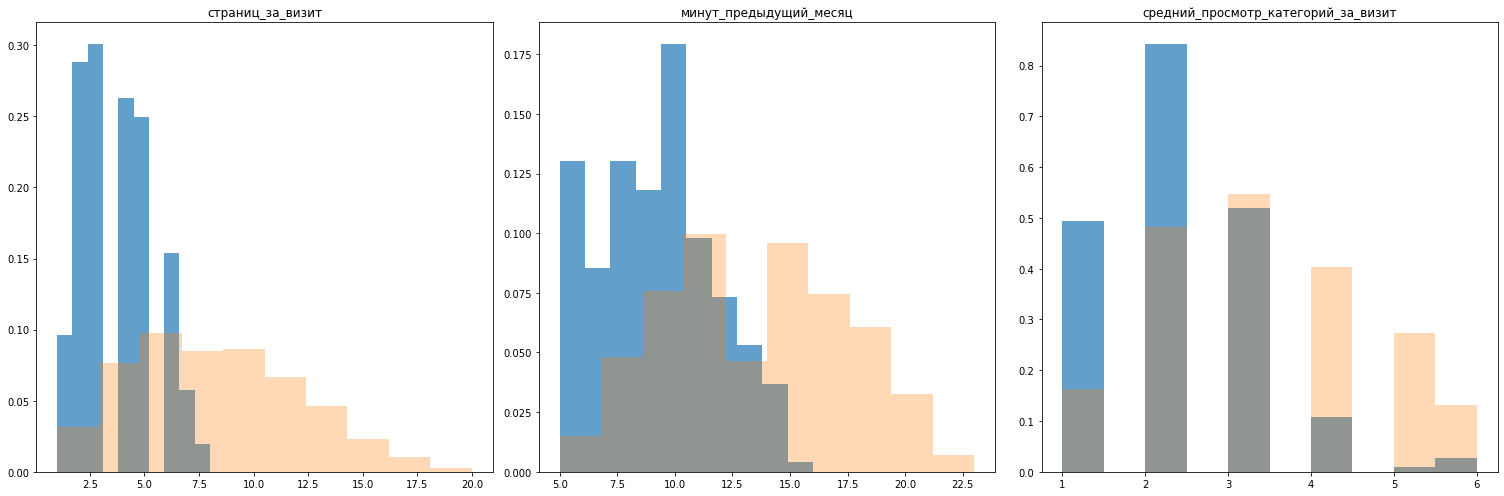

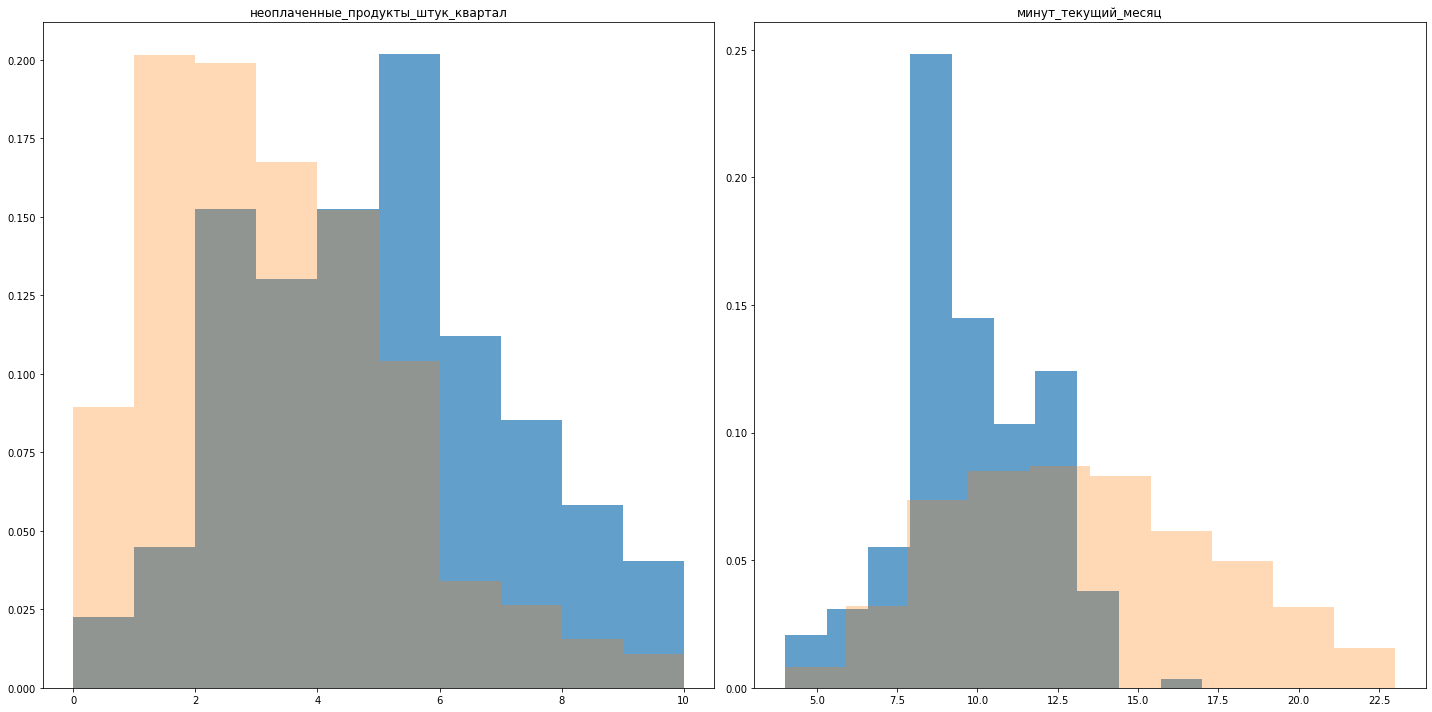

In [ ]:
plt.figure(figsize=(21, 7))

plt.subplot(1, 3, 1)
plt.hist(df_seg_money['страниц_за_визит'], bins=10, alpha=0.7, density=True)
plt.hist(X['страниц_за_визит'], bins=10, alpha=0.3, density=True)
plt.title('страниц_за_визит')

plt.subplot(1, 3, 2)
plt.hist(df_seg_money['минут_предыдущий_месяц'], bins=10, alpha=0.7, density=True)
plt.hist(X['минут_предыдущий_месяц'], bins=10, alpha=0.3, density=True)
plt.title('минут_предыдущий_месяц')

plt.subplot(1, 3, 3)
plt.hist(df_seg_money['средний_просмотр_категорий_за_визит'], bins=10, alpha=0.7, density=True)
plt.hist(X['средний_просмотр_категорий_за_визит'], bins=10, alpha=0.3, density=True)
plt.title('средний_просмотр_категорий_за_визит')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.hist(df_seg_money['неоплаченные_продукты_штук_квартал'], bins=10, alpha=0.7, density=True)
plt.hist(X['неоплаченные_продукты_штук_квартал'], bins=10, alpha=0.3, density=True)
plt.title('неоплаченные_продукты_штук_квартал')

plt.subplot(1, 2, 2)
plt.hist(df_seg_money['минут_текущий_месяц'], bins=10, alpha=0.7, density=True)
plt.hist(X['минут_текущий_месяц'], bins=10, alpha=0.3, density=True)
plt.title('минут_текущий_месяц')

plt.tight_layout()
plt.show()

При рассмотрении наиболее значимых признаков в сегменте пользователей, отобранных моделью как те, у которых снизится покупальская активность, в сравнении с общей популяцией можно сделать вывод: 
- Касательно признака числа страниц за визит, у пользователей из выделенного сегмента среднее число просмотренных страниц ниже и смещено в меньную сторону (4 против 8 у общей группы)
- Признак времени, проведенного на сайте так же ниже, но не значительно, так в общей популяции медиана времени составляет порядка 13 минут, у данных пользователей порядка 10 минут.
- Просмотренные категории у селективной группы ниже и составляет в среднем 2 категории, в противовес 3 у общей группы
- Неоплаченные товары в корзине, напротив имеют большее количество у отобранной группы (5 против 3 у общей группы) 

Таким образом рассмотрен сегмент покупателей, параметры которых наиболее вероятно приведут к снижению покупательской активности.
Учитывая сегментные данные можно предложить магазину провести промоакцию, которая заставит пользователей просматривать больше страниц, больше категорий товаров, а так же можно попробовать предложить оплачивать находящиеся товары в корзине по индивидуальной программе (например делать скидки, если пользователь оплатит товар в течении какого-либо времени после добавления в корзину) 


## Итоговый вывод

1. Была поставлена задача разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность. Для этого необоходимо создать модель машинного обучения и проанализировать определенный сегмент покупателей
2. С этой целью были даны исходные табличные данные с информацией о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. Данные о выручке, которую получает магазин с покупателя. Данные о времени, которое покупатель провёл на сайте. Данные о среднемесячной прибыли покупателя за последние 3 месяца.
Была выполнена предобработка первичных данных: названия колонок были приведены к общему виду, исправлены опечатки в категориальных данных, датафреймы исследованы на наличие дупликатов
3.С целью поиска лучше модели был выполнен корреляционный анализ данных, синтезированы объединенные данные, проведен разведочный анализ данных, выполнен полный пайплайн по предобработке данных и поиску лучше модели машинного обучения.
Лучшей моделью показала себя логистическая регрессия
4. Рассмотрен сегмент покупателей, параметры которых наиболее вероятно приведут к снижению покупательской активности.
На основе анализа данных клиентов для них можно разработать ряд индивидуальных предложений:
    - можно попробовать предложить оплачивать находящиеся товары в корзине по индивидуальной программе (например делать скидки,      если пользователь оплатит товар в течении какого-либо времени после добавления в корзину)
    - При большем просмотре категорий магазина для таких клиентов можно формировать специальные предложения.
